In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Atrous Convolution

In [2]:
class Atrous_convolution(nn.Module):

    def __init__(self, input_channels, kernel_size, pad, dilation_rate, output_channels=256):
        super(Atrous_convolution, self).__init__()

        self.conv = nn.Conv2d(in_channels=input_channels, out_channels=output_channels,
                              kernel_size = kernel_size, padding = pad, dilation=dilation_rate, bias = False)
        self.batchnorm = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x

# Atrous Spatial Pyramid Pooling

In [3]:
class ASPP(nn.Module):

    def __init__(self, in_channels, out_channels):

        super(ASPP, self).__init__()

        self.conv_1 = Atrous_convolution(input_channels = in_channels, kernel_size = 1, 
                                         pad = 0, dilation_rate=1, output_channels=out_channels)

        self.conv_6 = Atrous_convolution(input_channels = in_channels, kernel_size = 3, 
                                         pad = 6, dilation_rate=6, output_channels=out_channels)

        self.conv_12 = Atrous_convolution(input_channels = in_channels, kernel_size = 3, 
                                         pad = 12, dilation_rate=12, output_channels=out_channels)

        self.conv_18 = Atrous_convolution(input_channels = in_channels, kernel_size = 3, 
                                         pad = 18, dilation_rate=18, output_channels=out_channels)

        self.image_pool = nn.Sequential(
                                    nn.AdaptiveAvgPool2d(1),
                                    nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                              kernel_size=1, stride=1, padding=0, dilation=1, bias=False),
                                    nn.GroupNorm(num_groups=32, num_channels=256),
                                    nn.ReLU(inplace=True))

        self.final_conv = Atrous_convolution(
                                    input_channels=out_channels * 5, output_channels=out_channels,
                                    kernel_size=1, pad=0, dilation_rate=1)
        
    def forward(self, x):
        x_1x1 = self.conv_1(x)
        x_6x6 = self.conv_6(x)
        x_12x12 = self.conv_12(x)
        x_18x18 = self.conv_18(x)
        
        img_pool_opt = self.image_pool(x)
        img_pool_opt = F.interpolate(
            img_pool_opt, size=x_18x18.size()[2:],
            mode='bilinear', align_corners=True)
    
        concat = torch.cat(
            (x_1x1, x_6x6, x_12x12, x_18x18, img_pool_opt),
            dim=1)
        x_final_conv = self.final_conv(concat)
        return x_final_conv

In [4]:
from torchvision.models import resnet50, ResNet50_Weights

class ResNet_50(nn.Module):
    def __init__(self, output_layer):
        super(ResNet_50, self).__init__()
        self.pretrained = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.layers = list(self.pretrained._modules.keys())
        self.layer_count = self.layers.index(output_layer) + 1

        # Remove unnecessary layers after the target output layer
        for i in range(1, len(self.layers) - self.layer_count + 1):
            self.pretrained._modules.pop(self.layers[-i])

        self.net = nn.Sequential(*self.pretrained._modules.values())
        self.pretrained = None

    def forward(self, x):
        return self.net(x)


In [5]:
class Deeplabv3Plus(nn.Module):
    def __init__(self, num_classes):

        super(Deeplabv3Plus, self).__init__()

        self.backbone = ResNet_50(output_layer='layer3')

        self.low_level_features = ResNet_50(output_layer='layer1')

        self.aspp = ASPP(in_channels=1024, out_channels=256)

        self.conv1x1 = Atrous_convolution(
            input_channels=256, output_channels=48, kernel_size=1,
            dilation_rate=1, pad=0)

        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(304, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.classifer = nn.Conv2d(256, num_classes, 1)

    def forward(self, x):

        x_backbone = self.backbone(x)
        x_low_level = self.low_level_features(x)
        x_aspp = self.aspp(x_backbone)
        x_aspp_upsampled = F.interpolate(
            x_aspp, scale_factor=(4, 4),
            mode='bilinear', align_corners=True)
        x_conv1x1 = self.conv1x1(x_low_level)
        x_cat = torch.cat([x_conv1x1, x_aspp_upsampled], dim=1)
        x_3x3 = self.conv_3x3(x_cat)
        x_3x3_upscaled = F.interpolate(
            x_3x3, scale_factor=(4, 4),
            mode='bilinear', align_corners=True)
        x_out = self.classifer(x_3x3_upscaled)
        return x_out

In [ ]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# ----------------------- Color Palette and Name Setup -----------------------
names = ['unlabeled', 'dynamic', 'ground', 'road', 'sidewalk', 'parking', 'rail track', 'building', 'wall',
         'fence', 'guard rail', 'bridge', 'tunnel', 'pole', 'traffic light', 'traffic sign', 'vegetation',
         'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'caravan', 'trailer', 'train', 'motorcycle',
         'bicycle', 'license plate']

colors = np.array([
    (0, 0, 0), (111, 74, 0), (81, 0, 81), (128, 64, 128), (244, 35, 232), (250, 170, 160),
    (230, 150, 140), (70, 70, 70), (102, 102, 156), (190, 153, 153), (180, 165, 180),
    (150, 100, 100), (150, 120, 90), (153, 153, 153), (250, 170, 30), (220, 220, 0),
    (107, 142, 35), (152, 251, 152), (70, 130, 180), (220, 20, 60), (255, 0, 0),
    (0, 0, 142), (0, 0, 70), (0, 60, 100), (0, 0, 90), (0, 0, 110), (0, 80, 100),
    (0, 0, 230), (119, 11, 32), (0, 0, 142)
], dtype=np.int32)

# ----------------------- Utility Function -----------------------
def rgb_to_class(mask):
    h, w, _ = mask.shape
    mask_class = np.zeros((h, w), dtype=np.uint8)
    for class_index, color in enumerate(colors):
        mask_class[np.all(mask == color, axis=-1)] = class_index
    return mask_class

# ----------------------- Dataset Class -----------------------
class CityscapesDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace(".png", ".png"))  # Same name

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("RGB"))
        mask = rgb_to_class(mask)  # Convert RGB to class indices

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

        return image, mask.long()

# ----------------------- Transform -----------------------
transform = A.Compose([
    A.Resize(256, 512),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

# ----------------------- Paths -----------------------
img_dir = r'D:\AIML Resources\SoC 2025\cityscapes\train\img'
mask_dir = r'D:\AIML Resources\SoC 2025\cityscapes\train\label'

# ----------------------- Dataloader -----------------------
train_dataset = CityscapesDataset(img_dir, mask_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=0)

# ----------------------- Load Model -----------------------

model = Deeplabv3Plus(num_classes=30).cuda()

# Fix for image-level pooling: GroupNorm instead of BatchNorm in ASPP
# (Assuming you've already made this fix in your model)

# ----------------------- Optimizer and Loss -----------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ----------------------- Training Loop -----------------------
num_epochs = 20
model.train()

for epoch in range(num_epochs):
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
    for images, masks in loop:
        images, masks = images.cuda(), masks.cuda()

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    print(f"Epoch [{epoch+1}] - Avg Loss: {total_loss / len(train_loader):.4f}")

Epoch [1/20]:   0%|▏                                                        | 2/496 [00:04<16:52,  2.05s/it, loss=3.24]

In [15]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torch

def rgb_to_class(mask_rgb):
    class_map = {
        (0, 0, 0): 0, (111, 74, 0): 1, (81, 0, 81): 2, (128, 64, 128): 3,
        (244, 35, 232): 4, (250, 170, 160): 5, (230, 150, 140): 6,
        (70, 70, 70): 7, (102, 102, 156): 8, (190, 153, 153): 9,
        (180, 165, 180): 10, (150, 100, 100): 11, (150, 120, 90): 12,
        (153, 153, 153): 13, (250, 170, 30): 14, (220, 220, 0): 15,
        (107, 142, 35): 16, (152, 251, 152): 17, (70, 130, 180): 18,
        (220, 20, 60): 19, (255, 0, 0): 20, (0, 0, 142): 21,
        (0, 0, 70): 22, (0, 60, 100): 23, (0, 0, 90): 24,
        (0, 0, 110): 25, (0, 80, 100): 26, (0, 0, 230): 27,
        (119, 11, 32): 28, (0, 0, 142): 29,
    }

    h, w, _ = mask_rgb.shape
    mask_class = np.zeros((h, w), dtype=np.int64)

    for rgb, class_idx in class_map.items():
        mask_class[np.all(mask_rgb == rgb, axis=-1)] = class_idx

    return mask_class

class CityscapesDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace(".png", ".png"))

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("RGB"))
        mask = rgb_to_class(mask)

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

        return image, mask.long()



In [12]:
import torch
import numpy as np
from tqdm import tqdm

def compute_pixel_accuracy(preds, labels):
    correct = (preds == labels).sum()
    total = labels.numel()
    return correct.float() / total

def validate(model, dataloader, device):
    model.eval()
    pixel_accuracies = []

    with torch.no_grad():
        for imgs, masks in tqdm(dataloader, desc="Validating"):
            imgs = imgs.to(device)
            masks = masks.to(device)

            outputs = model(imgs)                  # [B, C, H, W]
            preds = torch.argmax(outputs, dim=1)   # [B, H, W]

            acc = compute_pixel_accuracy(preds, masks)
            pixel_accuracies.append(acc.item())

    mean_pixel_acc = np.mean(pixel_accuracies)
    print(f"\n✅ Mean Pixel Accuracy: {mean_pixel_acc:.4f}")
    return mean_pixel_acc



In [19]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader

# Paths
val_img_dir = r'D:\AIML Resources\SoC 2025\cityscapes\val\img'
val_mask_dir = r'D:\AIML Resources\SoC 2025\cityscapes\val\label'
NUM_CLASSES = 30

# Transformations
val_transform = A.Compose([
    A.Resize(256, 512),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

# Dataset and loader
val_dataset = CityscapesDataset(val_img_dir, val_mask_dir, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=6, shuffle=False)

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Deeplabv3Plus(num_classes=NUM_CLASSES).to(device)
model.eval()

# Validate
validate(model, val_loader, device)

Validating: 100%|██████████████████████████████████████████████████████████████████████| 84/84 [00:41<00:00,  2.00it/s]


✅ Mean Pixel Accuracy: 0.3495


np.float64(0.34954949876382235)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9921569..1.0].


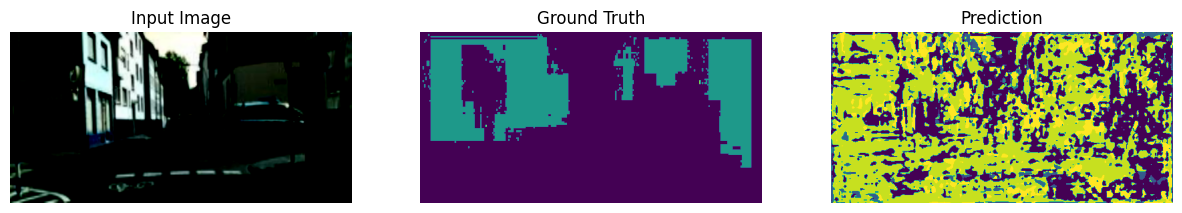

In [25]:
import matplotlib.pyplot as plt

def visualize_prediction(model, dataset, device, idx=0):
    model.eval()
    image, true_mask = dataset[idx]
    image = image.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        pred_mask = torch.argmax(output.squeeze(), dim=0).cpu()

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(image.squeeze().permute(1, 2, 0).cpu())
    axs[0].set_title("Input Image")
    axs[1].imshow(true_mask)
    axs[1].set_title("Ground Truth")
    axs[2].imshow(pred_mask)
    axs[2].set_title("Prediction")
    for ax in axs:
        ax.axis('off')
    plt.show()

# Example: visualize index 0
visualize_prediction(model, val_dataset, device, idx=0)

In [26]:
torch.save(model.state_dict(), 'deeplabv3plus_weights.pth')

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# Load model with trained weights
model = Deeplabv3Plus(num_classes=30).to(device)  # Keep num_classes same as before

# Load weights
model.load_state_dict(torch.load("deeplabv3plus_weights.pth", map_location=device))
model.eval()  # Important: set to evaluation mode

C:\Users\ankus\AppData\Local\Temp\ipykernel_6076\1271953050.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("deeplabv3plus_weights.pth",

Deeplabv3Plus(
  (backbone): ResNet_50(
    (pretrained): None
    (net): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): R

In [9]:
from torchvision.models.segmentation import deeplabv3_resnet101

pretrained_model = deeplabv3_resnet101(pretrained=True).to(device)
pretrained_model.eval()

C:\Users\ankus\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ankus\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [10]:
def validate_pretrained(model, dataloader, device):
    model.eval()
    pixel_accuracies = []

    with torch.no_grad():
        for imgs, masks in tqdm(dataloader, desc="Validating Pretrained Model"):
            imgs = imgs.to(device)
            masks = masks.to(device)

            outputs = model(imgs)['out']  # Extract tensor from OrderedDict
            preds = torch.argmax(outputs, dim=1)

            acc = compute_pixel_accuracy(preds, masks)
            pixel_accuracies.append(acc.item())

    print(f"✅ Pretrained Model Mean Pixel Accuracy: {np.mean(pixel_accuracies):.4f}")


In [20]:
# For your scratch model
print("▶️ Custom Model:")
validate(model, val_loader, device)

# For pretrained model
print("▶️ Pretrained Model:")
validate_pretrained(pretrained_model, val_loader, device)


▶️ Custom Model:


Validating: 100%|██████████████████████████████████████████████████████████████████████| 84/84 [00:45<00:00,  1.85it/s]



✅ Mean Pixel Accuracy: 0.3512
▶️ Pretrained Model:


Validating Pretrained Model: 100%|█████████████████████████████████████████████████████| 84/84 [01:11<00:00,  1.17it/s]

✅ Pretrained Model Mean Pixel Accuracy: 0.8275


In [21]:
import matplotlib.pyplot as plt
import torch

def show_images_with_masks(dataset, num_images=5, class_palette=None):
    """
    Show a few images and their corresponding segmentation masks.

    Args:
        dataset (torch.utils.data.Dataset): Your dataset object (must return image, mask).
        num_images (int): Number of samples to show.
        class_palette (dict or list, optional): Optional mapping from class index to RGB color.
    """
    plt.figure(figsize=(15, num_images * 3))

    for i in range(num_images):
        image, mask = dataset[i]
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).numpy()
        if isinstance(mask, torch.Tensor):
            mask = mask.numpy()

        # Apply color palette if provided
        if class_palette:
            mask_rgb = np.zeros((*mask.shape, 3), dtype=np.uint8)
            for k, color in class_palette.items():
                mask_rgb[mask == k] = color
        else:
            mask_rgb = mask

        # Plot image
        plt.subplot(num_images, 2, 2 * i + 1)
        plt.imshow(image.astype('uint8'))
        plt.title(f"Image {i}")
        plt.axis('off')

        # Plot mask
        plt.subplot(num_images, 2, 2 * i + 2)
        plt.imshow(mask_rgb)
        plt.title(f"Mask {i}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [24]:
# Assuming your training dataset is named `train_dataset`
# and class_palette is a dictionary like: {0: [0,0,0], 1: [128,0,0], ..., 29: [0,64,128]}

show_images_with_masks(train_dataset, num_images=5, class_palette=cityscapes_palette)


NameError: name 'train_dataset' is not defined